

# 🧪 Modeling with Duke NIfTI 3D files

After downloading TCIA data and converting it to niftii files, Or downloading minimal croped niftii version from zendoo, We can start modeling on Duke data.
```
Author: Itamar Barnea
Date: 2025-04-01
Version: 1.0
Description: Module for using ML/DL on Duke niftii data
```

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

# Path setup

In [86]:
my_computer=True
my_colab=False
use_git_samples=False

# Root Directory where the nifti data will be places
base_path = "G:\\My Drive\\breast_mri"

In [87]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')
        
    my_colab = True    
    base_path='/content/BreastDCEDL'

In [88]:
# setup directories of niftii data of I-SPY1, I-SPY2 and duke
    
nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","dce")}

mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}

if use_git_samples:
    # use for data_samples
    if use_git_samples:
        nifti_path= {'spy2':os.path.join(base_path,"SPY2","data_samples","dce"),
                            'spy1':os.path.join(base_path,"SPY1","data_samples","dce"),
                            'duke':os.path.join(base_path,"DUKE","data_samples","dce")}

        mask_path={'spy2':os.path.join(base_path,"SPY2","data_samples","mask"),
                        'spy1':os.path.join(base_path,"SPY1","data_samples","mask"),
                        'duke':os.path.join(base_path,"DUKE","data_samples")}
        

In [89]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../', 'utils')))

import data_utils as ds

ds.setup_paths(base_path, nifti_path, mask_path)

{'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\dce'} {'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\mask', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\mask'}


In [90]:
df = pd.read_csv('BreastDCEDL_duke_metadata.csv')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pid               922 non-null    object 
 1   n_xy              922 non-null    int64  
 2   ER                922 non-null    int64  
 3   PR                922 non-null    int64  
 4   HER2              922 non-null    int64  
 5   Mol_Subtype       922 non-null    int64  
 6   stage_tum_s       916 non-null    float64
 7   Tumor_Grade       907 non-null    float64
 8   Nottingham_grade  638 non-null    float64
 9   FOVcm             922 non-null    int64  
 10  slice_thick       922 non-null    float64
 11  age               922 non-null    int64  
 12  pCR               300 non-null    float64
 13  pCR_2             281 non-null    float64
 14  HR                922 non-null    int64  
 15  hormon_status     922 non-null    object 
 16  HR_HER2_STATUS    922 non-null    object 
 1

In [92]:
df[df.tum_vol.isna()][['pCR','pCR_2','tum_vol_2']]

pCR  pCR_2  tum_vol_2
129  NaN    NaN  14.349414
166  0.0    0.0   2.689756
249  NaN    NaN  18.404511
576  1.0    1.0  30.305375
645  NaN    NaN   3.589400
670  NaN    NaN   0.148889

# Visualize niftii and tumor bounding box

In [93]:
df.head(2)

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  Tumor_Grade  \
0  Breast_MRI_001   448   0   0     1            2          2.0          3.0   
1  Breast_MRI_002   512   0   0     0            3          2.0          3.0   

   Nottingham_grade  FOVcm  ...   ecol  mask_start  mask_end    n_z  n_times  \
0               2.0     15  ...  341.0        89.0     112.0  160.0      5.0   
1               3.0      5  ...  136.0        59.0      72.0  142.0      4.0   

  xy_spacing voxel_z  pre  post_early  post_late  
0   0.803571     1.1    0           1        4.0  
1   0.585900     1.3    0           1        3.0  

[2 rows x 40 columns]

In [94]:

r=df.iloc[200]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['post_late']) # last acqisition

Breast_MRI_201


In [95]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(96, 115, 136, 166, 72, 103, (176, 448, 448))

In [96]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

(176, 448, 448)

<Figure size 640x480 with 0 Axes>

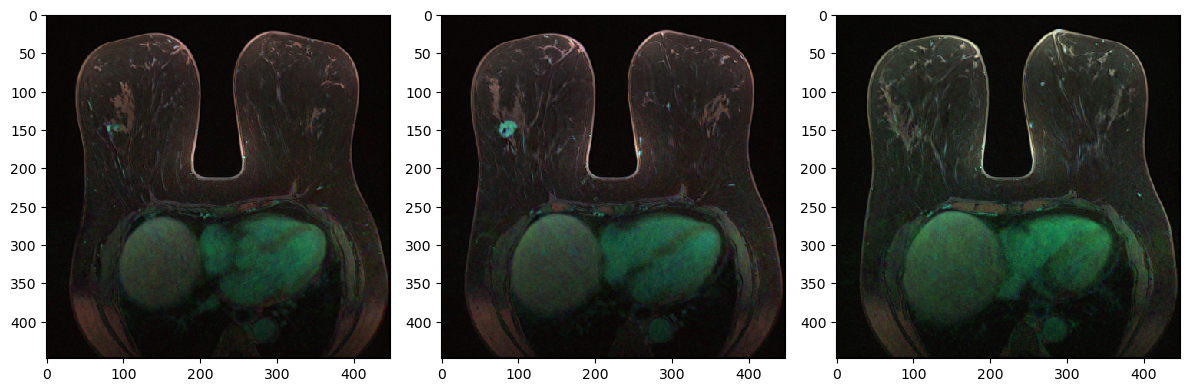

<Figure size 640x480 with 0 Axes>

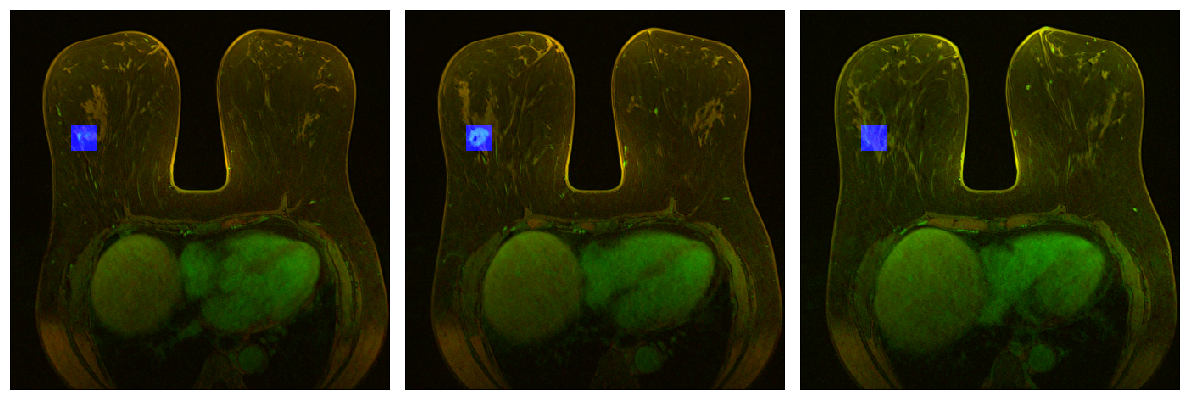

<Figure size 640x480 with 0 Axes>

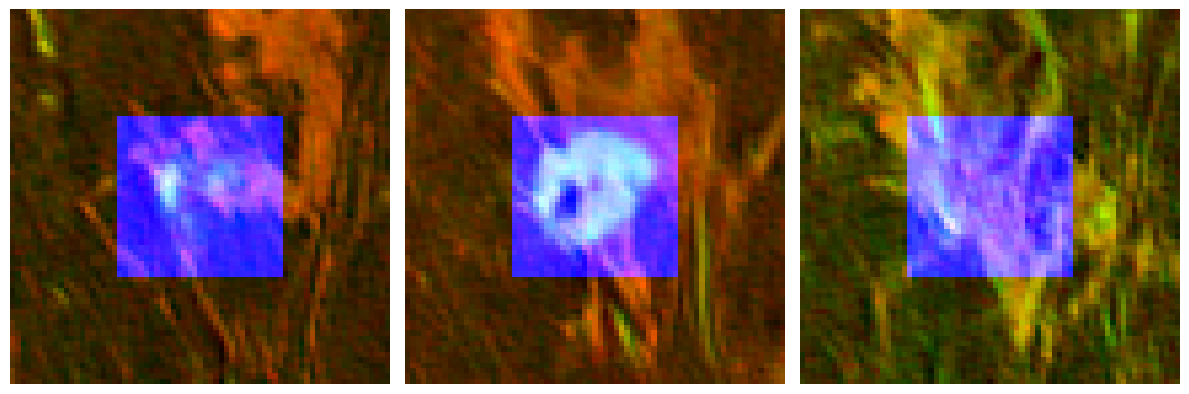

<Figure size 640x480 with 0 Axes>

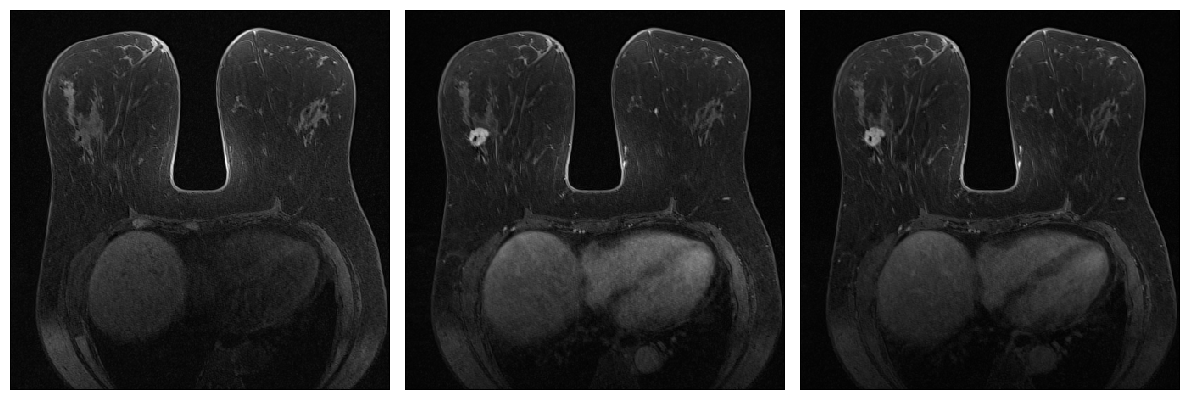

<Figure size 640x480 with 0 Axes>

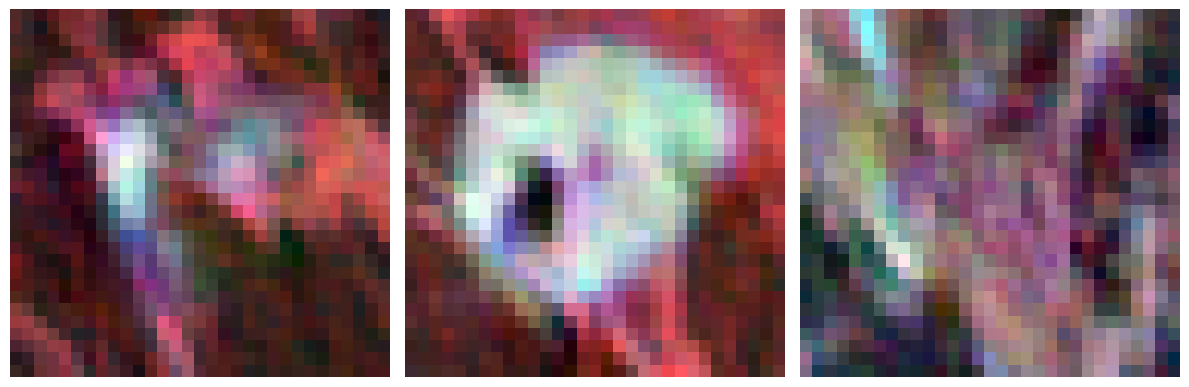

<Figure size 640x480 with 0 Axes>

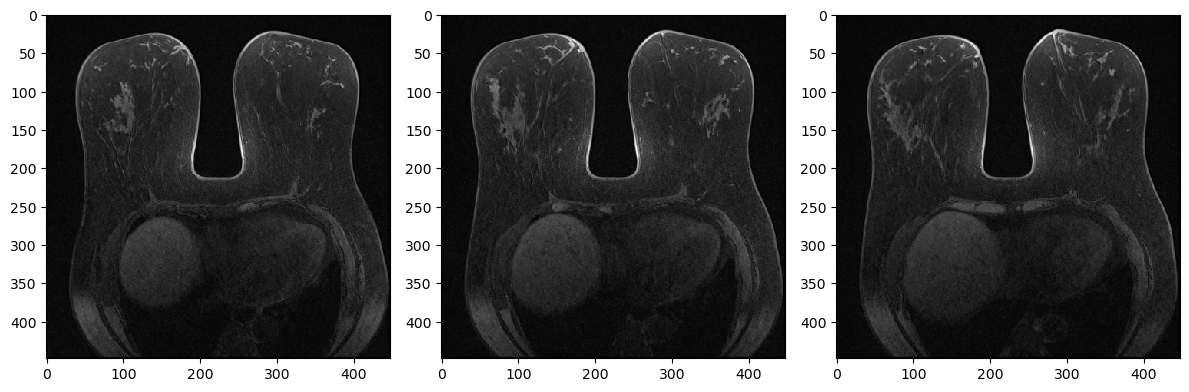

<Figure size 640x480 with 0 Axes>

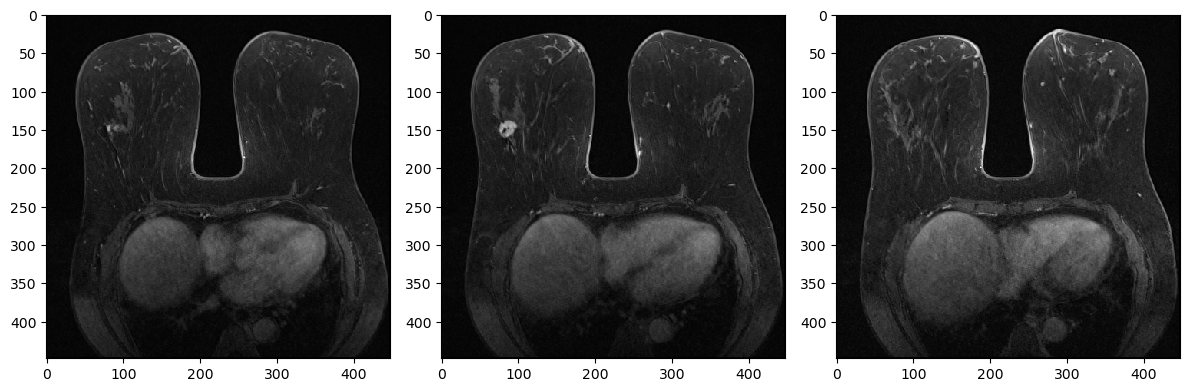

<Figure size 640x480 with 0 Axes>

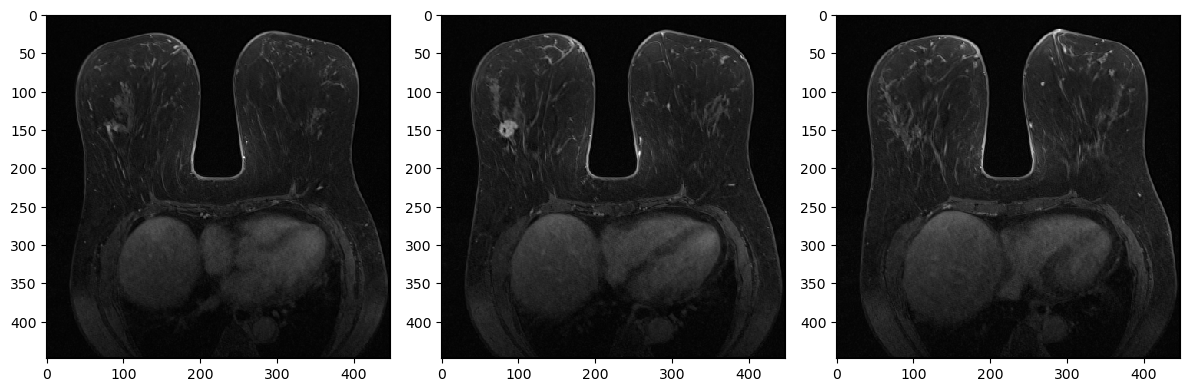

In [97]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            m[k]],axis=2 ) for k in idx])
ds.show_n_images([np.stack([ds.minmax(a0[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            ds.minmax(a1[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            m[k,sraw-20:eraw+20,scol-20:ecol+20]],axis=2 ) for k in idx])
ds.show_n_images([ds.minmax(a0[idx[1]]), 
                                ds.minmax(a1[idx[1]]), 
                                             ds.minmax(a2[idx[1]])]) 

ds.show_n_images([ds.to_rgb(a0[k,sraw:eraw,scol:ecol],
                            a1[k,sraw:eraw,scol:ecol],
                            a2[k,sraw:eraw,scol:ecol])  for k in idx])
ds.show_n_images([a0[k] for k in idx], axis_off=False)
ds.show_n_images([a1[k] for k in idx], axis_off=False)
ds.show_n_images([a2[k] for k in idx], axis_off=False)

In [98]:

r=df.iloc[1]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['n_times']-1) # last acqisition

Breast_MRI_002


In [99]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(59, 72, 251, 294, 108, 136, (142, 512, 512))

In [100]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

(142, 512, 512)

<Figure size 640x480 with 0 Axes>

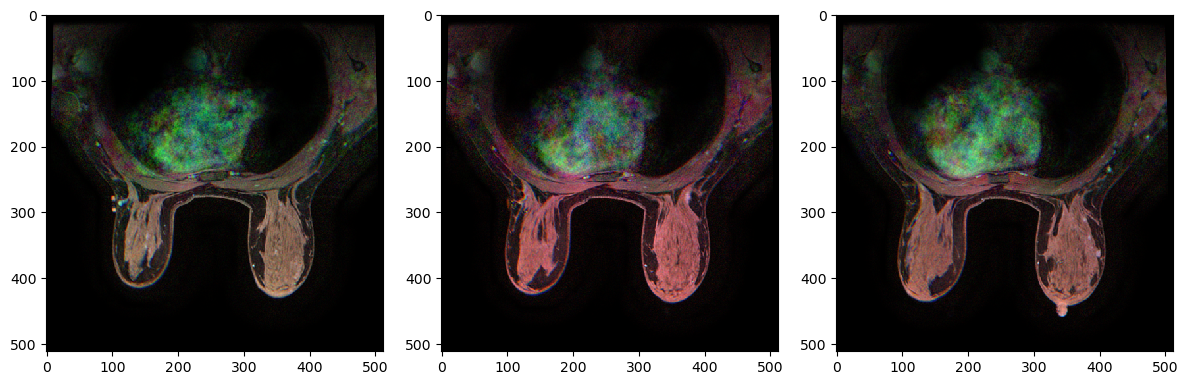

<Figure size 640x480 with 0 Axes>

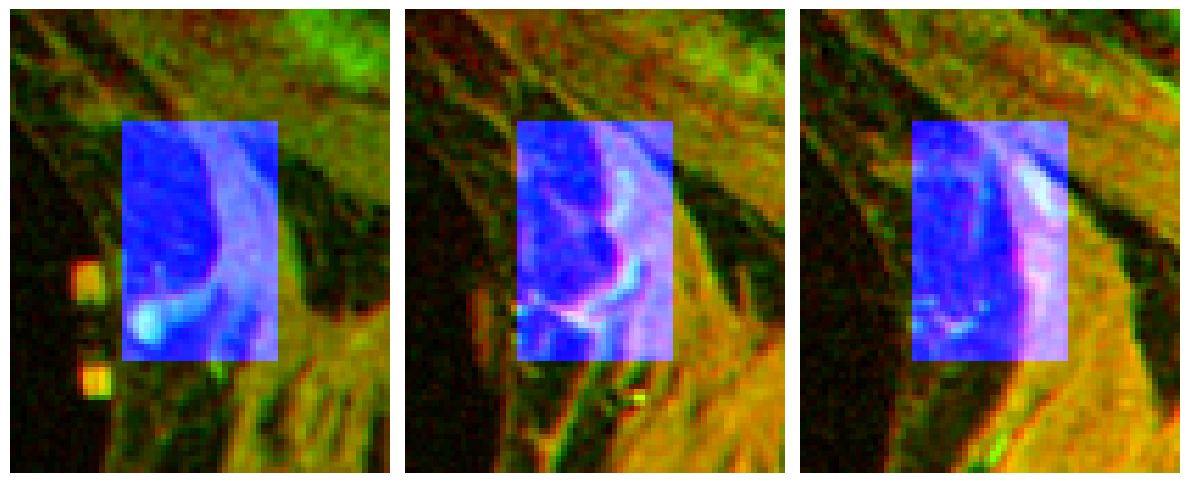

<Figure size 640x480 with 0 Axes>

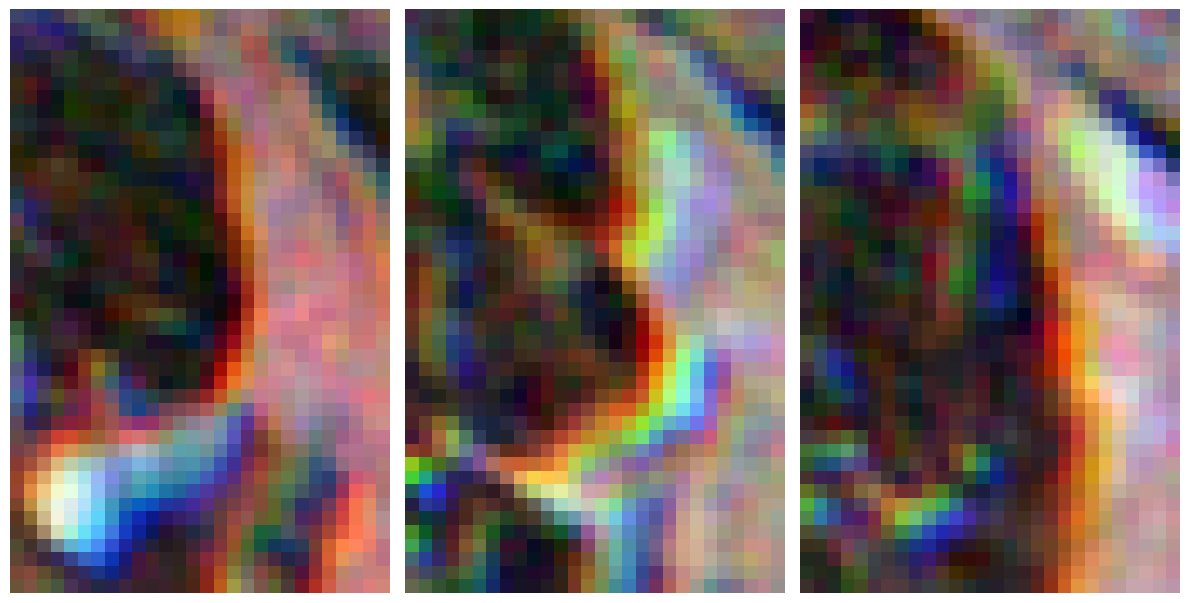

In [101]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            ds.minmax(a1[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            m[k,sraw-20:eraw+20,scol-20:ecol+20]],axis=2 ) for k in idx])

ds.show_n_images([ds.to_rgb(a0[k,sraw:eraw,scol:ecol],
                            a1[k,sraw:eraw,scol:ecol],
                            a2[k,sraw:eraw,scol:ecol])  for k in idx])


# Code to crop 

In [102]:
import numpy as np

def crop_around_voi(array_3d, voi, slice_padding=2, output_size=256):
    """
    Crop a 3D array around a VOI with padding, then extract a centered region of output_size.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array with shape (slices, rows, columns)
    voi : list or tuple
        VOI coordinates [sslc:eslc, srow:erow, scol:ecol]
    slice_padding : int
        Number of slices to pad before and after the VOI slice range
    output_size : int
        Size of the final square crop (output_size x output_size)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with shape (padded_slices, output_size, output_size)
    """
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    # Perform the crop
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array, (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [103]:
import numpy as np

def crop_around_voi_cords(array_3d_shape, voi, slice_padding=2, output_size=256):
    
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d_shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    
    
    return  (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [104]:
def crop_with_same_coordinates(array_3d, crop_coords):
    """
    Crop a 3D array using previously determined crop coordinates.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array to be cropped with shape (slices, rows, columns)
    crop_coords : tuple
        Coordinates from previous crop (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with same dimensions as the previously cropped array
    """
    # Unpack crop coordinates
    padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol = crop_coords
    
    # Check if coordinates are within bounds of the new array
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Validate slice coordinates
    if padded_eslc >= n_slices:
        raise ValueError(f"Slice end coordinate {padded_eslc} exceeds array dimension {n_slices}")
    
    # Validate row coordinates
    if crop_erow >= n_rows:
        raise ValueError(f"Row end coordinate {crop_erow} exceeds array dimension {n_rows}")
    
    # Validate column coordinates
    if crop_ecol >= n_cols:
        raise ValueError(f"Column end coordinate {crop_ecol} exceeds array dimension {n_cols}")
    
    # Perform the crop using the same coordinates
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array

# View example of cropped MRI scan

In [105]:

r=df.iloc[5]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['n_times']-1) # last acqisition

Breast_MRI_006


In [106]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(39, 48, 331, 371, 408, 434, (148, 512, 512))

In [107]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm+1,sraw:eraw,scol:ecol]=1
m.shape

(148, 512, 512)

In [108]:
# Example usage:
# Assuming array_3d has shape (120, 458, 458) and voi is defined as:
voi = [(startm,endm),(sraw,eraw),(scol,ecol)]  # [sslc:eslc, srow:erow, scol:ecol]

# Perform the crop
cropped_volume, crop_coords = crop_around_voi(a0, voi, slice_padding=2, output_size=256)

# Print results
print(f"Original shape: {a0.shape}")
print(f"Cropped shape: {cropped_volume.shape}")
print(f"Crop coordinates: {crop_coords}")
cropped_volume.shape,voi,voi[0][0],voi[0][1],crop_coords[0],crop_coords[1]

Original shape: (148, 512, 512)
Cropped shape: (14, 256, 256)
Crop coordinates: (37, 50, 223, 478, 255, 510)


((14, 256, 256), [(39, 48), (331, 371), (408, 434)], 39, 48, 37, 50)

In [109]:
ca0=cropped_volume

In [110]:
ca1 = crop_with_same_coordinates(a1, crop_coords)
ca2 = crop_with_same_coordinates(a1, crop_coords)
cm = crop_with_same_coordinates(m, crop_coords)
ca1.shape

(14, 256, 256)

[40, 43, 47] [3, 6, 10]


<Figure size 640x480 with 0 Axes>

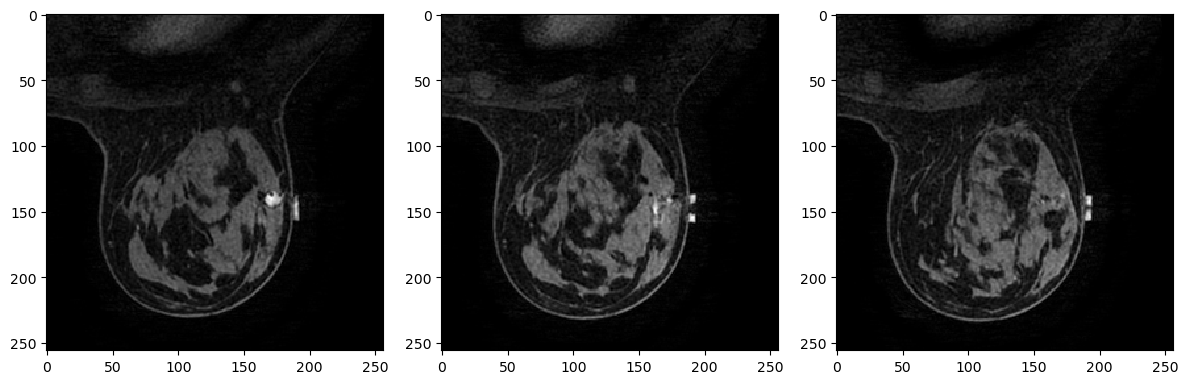

<Figure size 640x480 with 0 Axes>

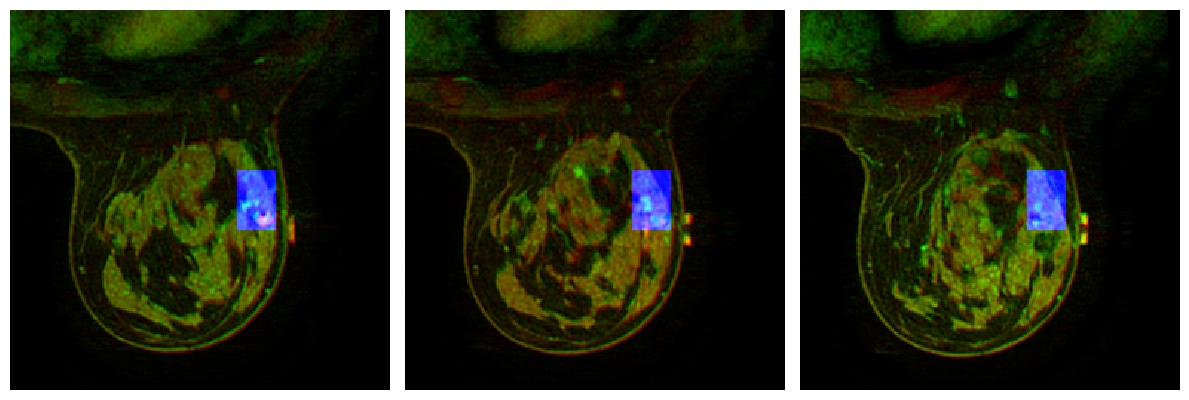

In [111]:
idx=[voi[0][0]+1,(voi[0][0]+voi[0][1])//2, voi[0][1]-1]
print(idx, [c-crop_coords[0] for c in idx])
ds.show_n_images([ca0[k-crop_coords[0]] for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(ca0[k-crop_coords[0]]) ,
                            ds.minmax(ca1[k-crop_coords[0]]) ,
                            cm[k-crop_coords[0]]],axis=2 ) for k in idx])




In [113]:
fpath="C:\\Users\\naomi\\Downloads\\breast_mri\\duke\\min_dce"

In [114]:
fpath="G:\\My Drive\\breast_mri\\DUKE\min_dce"

In [120]:
xx=pd.read_csv('../BreastDCEDL_metadata.csv')
pp=[p for p in df.pid.values if p not in xx.pid.values]
pp

['Breast_MRI_258',
 'Breast_MRI_282',
 'Breast_MRI_700',
 'Breast_MRI_728',
 'Breast_MRI_801',
 'Breast_MRI_893']

In [117]:
df[df.pid.isin(ppp)]

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  \
257  Breast_MRI_258   512   0   0     0            3          2.0   
281  Breast_MRI_282   448   0   0     0            3          2.0   
699  Breast_MRI_700   448   1   1     0            0          2.0   
727  Breast_MRI_728   448   1   1     0            0          1.0   
800  Breast_MRI_801   448   1   1     0            0          2.0   
892  Breast_MRI_893   448   0   0     0            3          1.0   

     Tumor_Grade  Nottingham_grade  FOVcm  ...   ecol  mask_start  mask_end  \
257          3.0               2.0     19  ...  203.0        56.0     157.0   
281          3.0               3.0     11  ...  103.0        96.0     116.0   
699          3.0               2.0     11  ...  338.0        86.0     113.0   
727          3.0               2.0     14  ...  151.0        78.0      89.0   
800          2.0               2.0     14  ...  342.0        71.0      96.0   
892          3.0               NaN     15  ...  358.0        84.0      89.0   

       n_z  n_times xy_spacing voxel_z  pre  post_early  post_late  
257    NaN      NaN        NaN     NaN    0           1        NaN  
281    NaN      NaN        NaN     NaN    0           1        NaN  
699  176.0      3.0   0.758929     1.0    0           1        2.0  
727  208.0      3.0   0.781250     1.0    0           1        2.0  
800  208.0      3.0   0.803571     1.2    0           1        2.0  
892  160.0      3.0   0.803571     1.2    0           1        2.0  

[6 rows x 40 columns]

In [128]:
gdf=pd.read_csv('../BreastDCEDL_metadata_from_git.csv')
gdf[~gdf.pCR.isna()].dataset.value_counts()
ppp=[p for p in df[~df.pCR.isna()].pid.values if p not in xx[~xx.pCR.isna()].pid.values]
ppp

['Breast_MRI_003',
 'Breast_MRI_053',
 'Breast_MRI_081',
 'Breast_MRI_089',
 'Breast_MRI_258',
 'Breast_MRI_282',
 'Breast_MRI_372',
 'Breast_MRI_376',
 'Breast_MRI_442',
 'Breast_MRI_450',
 'Breast_MRI_473',
 'Breast_MRI_596',
 'Breast_MRI_600',
 'Breast_MRI_626',
 'Breast_MRI_648',
 'Breast_MRI_705',
 'Breast_MRI_851',
 'Breast_MRI_857',
 'Breast_MRI_877',
 'Breast_MRI_900',
 'Breast_MRI_901']

In [130]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]

In [131]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df.iterrows():
        
        pid =  row['pid']
        #if pid != 'Breast_MRI_728': continue
        if pid not in ppp +pp : continue
            
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a0=ds.get_nifti_acquisition(pid, idx=0)
        
        if a0 is not None:
            if row['n_z'] is not None:
                z=int(row['n_z'])
                assert(a0.shape[0]==z)
            else:
                df_crop.at[i,'org_n_z']=a0.shape[0]
                print('correct n_z of ',pid,' to ',a0.shape[0])
        else:
            continue
            
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        assert(int(row['post_late'])==int(row['n_times']-1))
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=2, output_size=256)
        print(crop_coords)
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)
        
        ca0 = crop_with_same_coordinates(a0, crop_coords)
        ca1 = crop_with_same_coordinates(a1, crop_coords)
        ca2 = crop_with_same_coordinates(a2, crop_coords)
        c = [ca1,ca1,ca2]
        
        fn = pid+'_duke_aqc_0.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca0)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_1.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca1)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_'+str(int(i2))+'.nii.gz'
        ds.save_niftii(os.path.join(fpath, fn),ca2)
        print('saving:',os.path.join(fpath, fn))
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = ca0.shape[0]
        
        

2 Breast_MRI_003 96.0 108.0
2 --- Breast_MRI_003 (156, 512, 512)
(94, 110, 253, 508, 0, 255)
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_003_duke_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_003_duke_aqc_1.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_003_duke_aqc_4.nii.gz
ser: 0 1 4
52 Breast_MRI_053 81.0 104.0
52 --- Breast_MRI_053 (176, 512, 512)
(79, 106, 190, 445, 0, 255)
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_053_duke_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_053_duke_aqc_1.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_053_duke_aqc_3.nii.gz
ser: 0 1 3
80 Breast_MRI_081 92.0 122.0
80 --- Breast_MRI_081 (176, 448, 448)
(90, 124, 24, 279, 0, 255)
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_081_duke_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_081_duke_aqc_1.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_081_duke_aqc_3.nii.gz
ser

Breast_MRI_801 duke
no nifti files
==== No mask No BoundingBox


<Figure size 640x480 with 0 Axes>

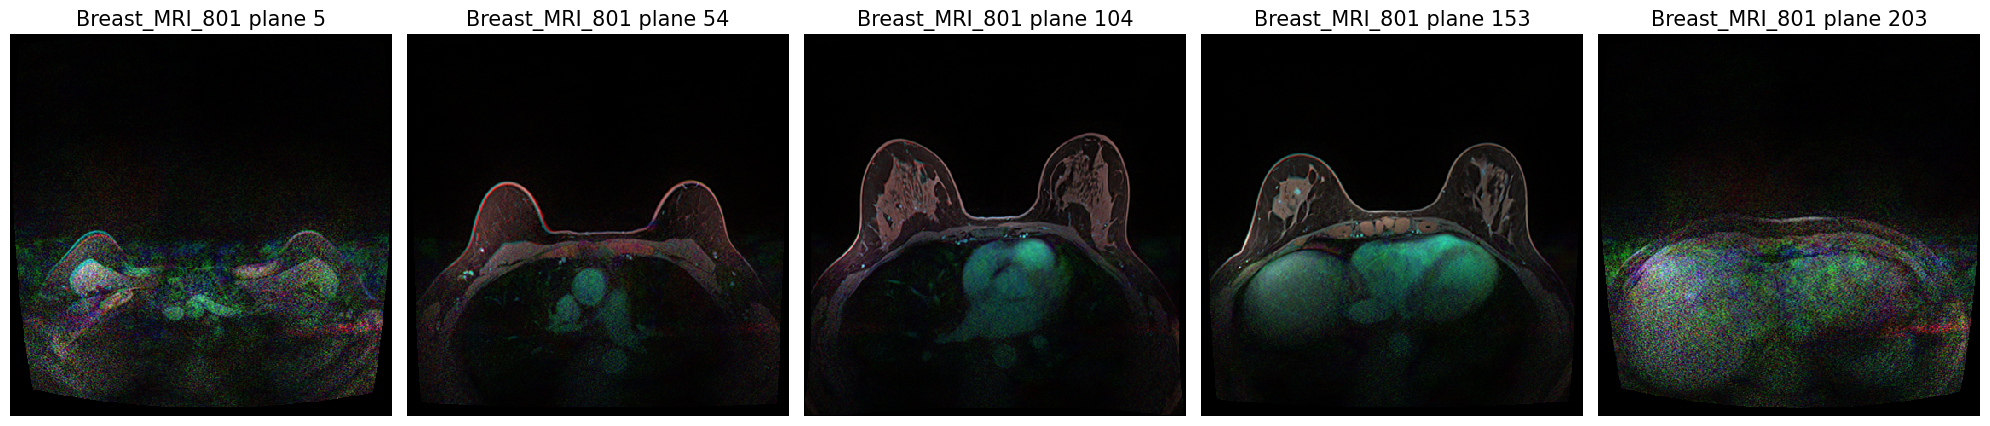

In [49]:
ds.show_pid('Breast_MRI_801',[0,1,2])

In [36]:
ca0.shape

(32, 256, 256)

In [64]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 68 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pid                       918 non-null    object 
 1   Slice_Thickness           918 non-null    int64  
 2   Rows                      918 non-null    int64  
 3   Columns                   918 non-null    int64  
 4   FOVcm                     918 non-null    int64  
 5   Date_of_Birth_(Days)      918 non-null    int64  
 6   Menopause_(at_diagnosis)  918 non-null    int64  
 7   Race_and_Ethnicity        918 non-null    int64  
 8   ER                        918 non-null    int64  
 9   PR                        918 non-null    int64  
 10  HER2                      918 non-null    int64  
 11  Mol_Subtype               918 non-null    int64  
 12  stage_tum_s               914 non-null    float64
 13  Tumor_Grade               905 non-null    float64
 14  Nottingham

In [68]:
df_crop.to_csv('BrestDCEDL_duke_cropped.csv', index = False)
df_crop.shape

(918, 68)

922 paitents, 6 had missing data, final 986